In [51]:
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
from torchvision import transforms
from torchvision import models
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.optim import lr_scheduler
from torch import optim
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import time
%matplotlib inline

In [52]:

def imshow(inp):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
   

```
    chapter3/
        dogsandcats/
            train/
                dog.183.jpg
                cat.2.jpg
                cat.17.jpg
                dog.186.jpg
                cat.27.jpg
                dog.193.jpg
  

```

```
    chapter3/
        dogsandcats/
            train/
                dog/
                    dog.183.jpg
                    dog.186.jpg
                    dog.193.jpg
                cat/
                    cat.17.jpg
                    cat.2.jpg
                    cat.27.jpg
            valid/
                dog/
                    dog.173.jpg
                    dog.156.jpg
                    dog.123.jpg
                cat/
                    cat.172.jpg
                    cat.20.jpg
                    cat.21.jpg

```



## Create validation data set

In [125]:
path = 'data/masks/train/no-mask/'
#path = '/Users/antoniocollante/Documents/Deep-Learning-with-PyTorch/Chapter03/dogsandcats'
#path = '/dogsandcats/'

In [135]:
files = glob(os.path.join(path,'*.*')) # add the extension
print(files)

[]


In [130]:
print(f'Total no of images {len(files)}')

Total no of images 240


In [122]:
no_of_images = 25000

In [131]:
no_of_images = len(files)
print(no_of_images)

240


In [132]:
no_of_images*0.8

192.0

In [133]:
shuffle = np.random.permutation(no_of_images)

In [108]:
#os.mkdir(os.path.join(path,'valid'))
try:
   if not os.path.exists(os.path.dirname(path)):
       os.makedirs(os.path.dirname(path))
except OSError as err:
   print(err)

In [107]:
for t in ['train','test']:
    
    for folder in ['no-mask/','surgical-mask/','cloth-mask/','improper-mask/','n95-mask']:
        print(os.path.join(path,t,folder))
        #os.mkdir(os.path.join(path,t,folder)) 


../data/masks/train/no-mask/train/no-mask/
../data/masks/train/no-mask/train/surgical-mask/
../data/masks/train/no-mask/train/cloth-mask/
../data/masks/train/no-mask/train/improper-mask/
../data/masks/train/no-mask/train/n95-mask
../data/masks/train/no-mask/test/no-mask/
../data/masks/train/no-mask/test/surgical-mask/
../data/masks/train/no-mask/test/cloth-mask/
../data/masks/train/no-mask/test/improper-mask/
../data/masks/train/no-mask/test/n95-mask


In [98]:
for i in shuffle[:2000]:
    #shutil.copyfile(files[i],'../chapter3/dogsandcats/valid/')
    folder = files[i].split('/')[-1].split('.')[0]
    image = files[i].split('/')[-1]
    os.rename(files[i],os.path.join(path,'test',folder,image))
    


In [99]:
for i in shuffle[2000:]:
    #shutil.copyfile(files[i],'../chapter3/dogsandcats/valid/')
    folder = files[i].split('/')[-1].split('.')[0]
    image = files[i].split('/')[-1]
    os.rename(files[i],os.path.join(path,'train',folder,image))



## Check if GPU is present

In [100]:

if torch.cuda.is_available():
    is_cuda = True

## Load data into PyTorch tensors

In [101]:
simple_transform = transforms.Compose([transforms.Resize((224,224))
                                       ,transforms.ToTensor()
                                       ,transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
train = ImageFolder('data/masks/train/',simple_transform)
test = ImageFolder('data/masks/test/',simple_transform)

In [102]:
print(train.class_to_idx)
print(train.classes) 


{'cloth-mask': 0, 'improper-mask': 1, 'n95-mask': 2, 'no-mask': 3, 'surgical-mask': 4}
['cloth-mask', 'improper-mask', 'n95-mask', 'no-mask', 'surgical-mask']


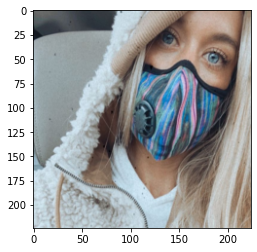

In [106]:
#imshow(train[50][0])
imshow(train[30][0])
print()
imshow(train[30][0])

## Create data generators

In [68]:
train_data_gen = torch.utils.data.DataLoader(train,shuffle=True,batch_size=64,num_workers=4)
test_data_gen = torch.utils.data.DataLoader(test,batch_size=64,num_workers=4)

In [69]:
dataset_sizes = {'train':len(train_data_gen.dataset),'test':len(test_data_gen.dataset)}

In [70]:
dataloaders = {'train':train_data_gen,'test':test_data_gen}

## Create a network

In [71]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 5)

if torch.cuda.is_available():
    model_ft = model_ft.cuda()

In [72]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [73]:
# Loss and Optimizer
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [74]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if torch.cuda.is_available():
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                #running_loss += loss.data[0]
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [75]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=2)

Epoch 0/1
----------
train Loss: 0.0224 Acc: 0.3674


rosetta error: ThreadContext::resume failed 4


RuntimeError: DataLoader worker (pid 66703) is killed by signal: Trace/BPT trap: 5. 